In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [5]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [6]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [7]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

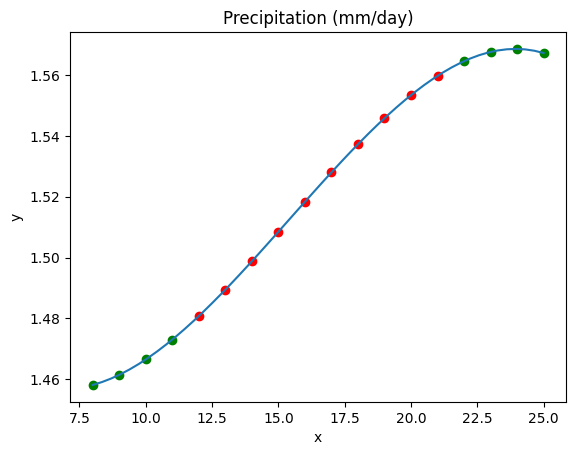

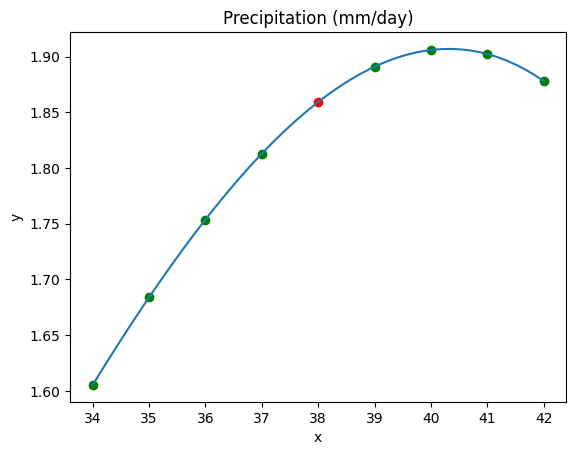

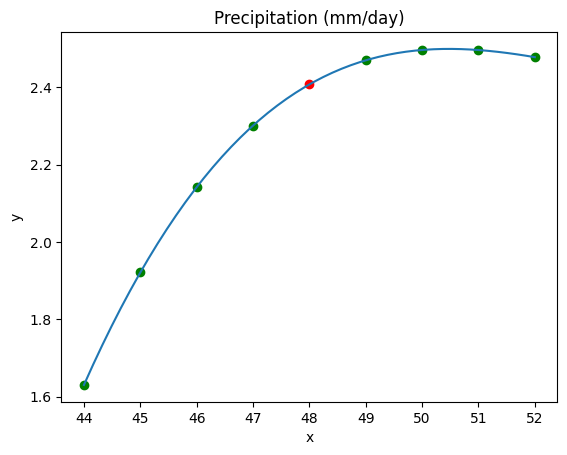

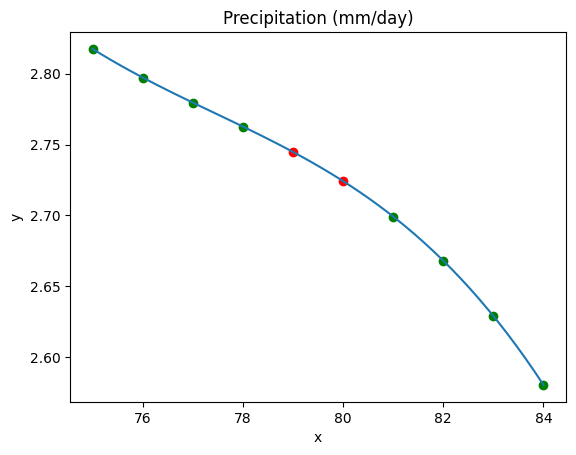

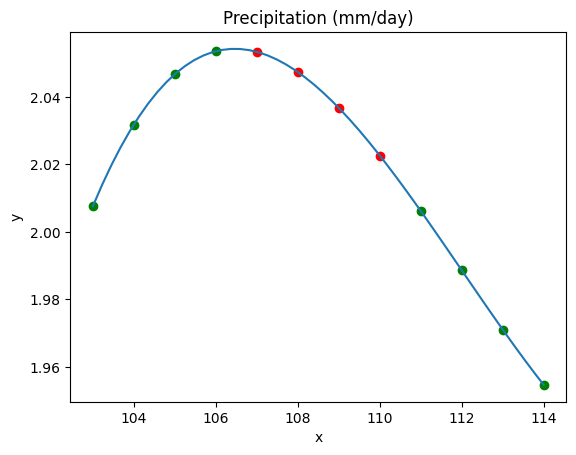

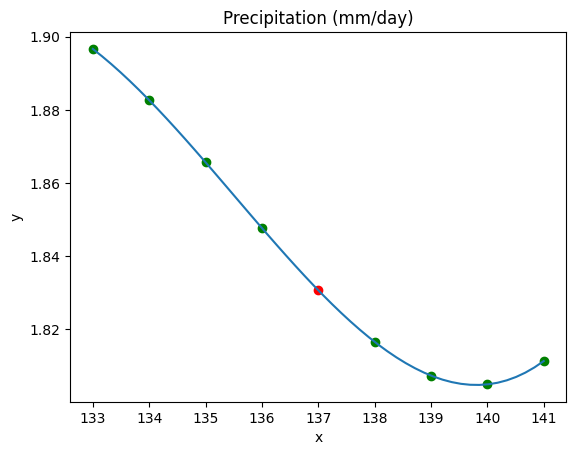

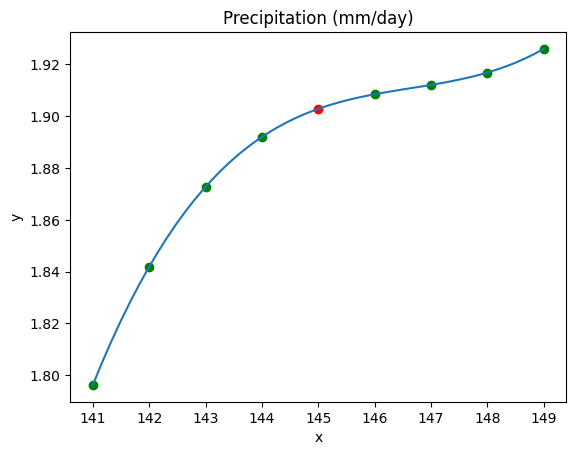

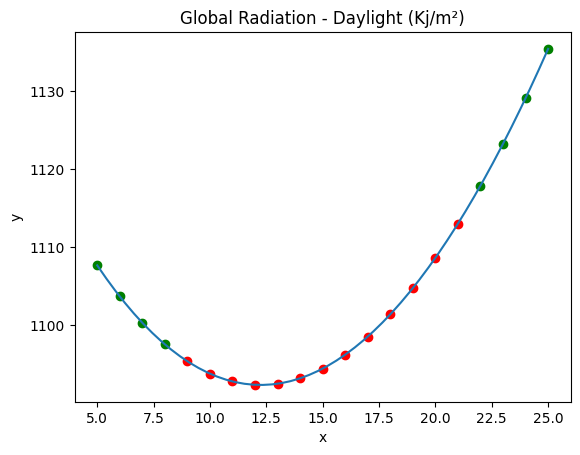

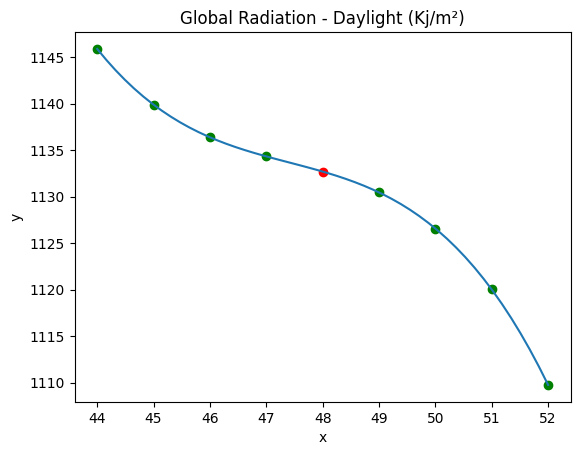

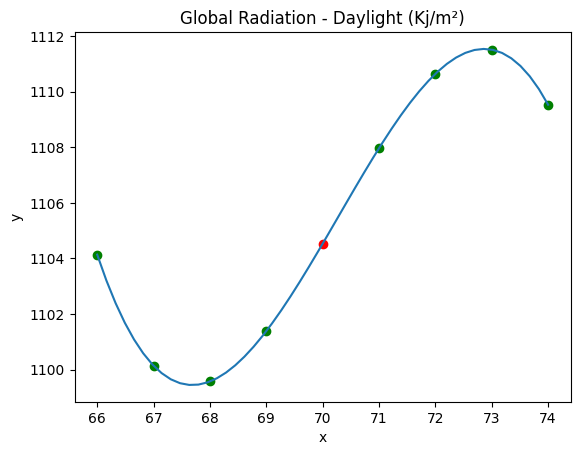

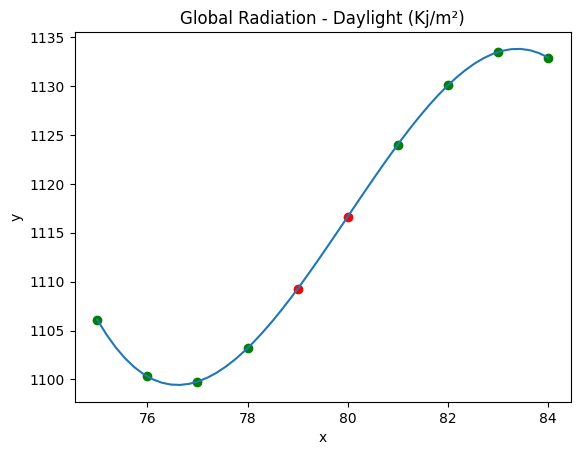

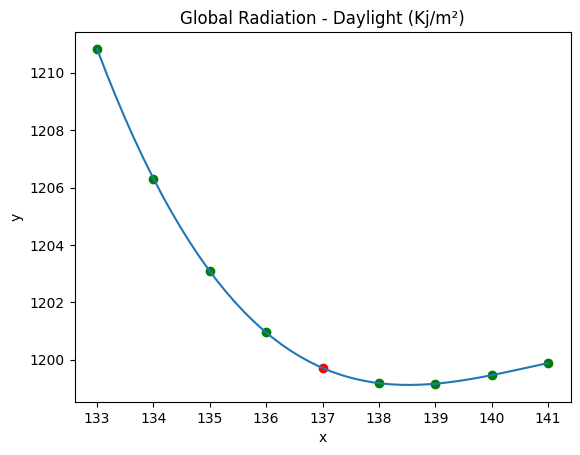

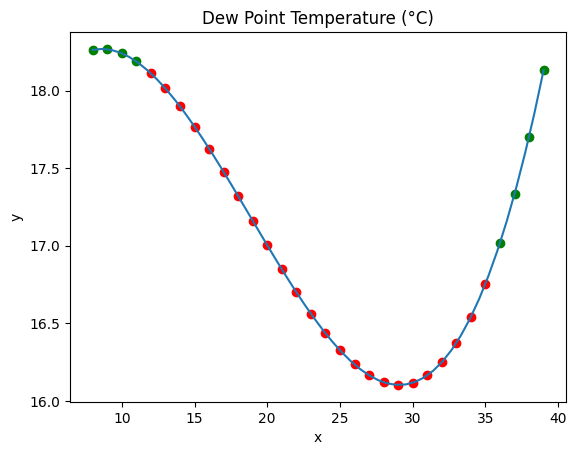

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2003,1.503596,1009.854529,1175.942510,26.991704,18.546007,66.508815,0.881809
1,2003,1.431472,1009.895602,1179.186933,26.934741,18.250333,66.476136,0.915359
2,2003,1.362041,1009.918569,1134.884790,26.857061,18.019427,66.804270,0.946718
3,2003,1.454954,1009.971590,1130.052974,26.838803,17.770094,66.846579,0.970154
4,2003,1.380664,1010.016686,1114.416626,26.762810,17.593372,66.910075,0.968485
...,...,...,...,...,...,...,...,...
235,2022,1.883185,1013.021964,1115.048451,22.502169,18.703921,80.034335,0.666935
236,2022,1.908603,1012.874933,1115.579919,22.565759,18.802402,80.153023,0.661397
237,2022,1.917716,1012.775369,1121.367176,22.656975,18.887855,80.090064,0.661822
238,2022,1.934923,1012.797982,1123.409855,22.614886,18.834321,80.010901,0.661942


In [8]:
df = read_csv_replace_missing_by_polynomial('rio_de_janeiro_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

In [9]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2003,17.414471,1009.988935,1118.818586,26.869869,18.036745,66.777512,0.959633
2004,18.346431,1010.671457,1103.275780,25.953791,17.373589,70.098960,0.962531
2005,18.939013,1011.825261,1150.001213,24.741422,16.298207,73.386822,0.949820
2006,22.899961,1012.255515,1154.373827,24.047847,18.160850,75.523920,0.945490
2007,31.018587,1012.285529,1110.694790,23.335065,18.679514,78.858203,0.869522
2008,36.697984,1012.203296,1103.619545,23.145598,19.041313,80.733596,0.819193
2009,32.933440,1012.149927,1113.135070,23.101387,19.160541,81.195790,0.873595
2010,29.177236,1012.427323,1141.349974,22.850128,18.952421,81.281067,0.913459
2011,25.153610,1012.733462,1164.724634,22.787473,18.939670,81.492721,0.874916


In [12]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,22.049108,1012.787954,1202.470602,23.235371,18.867735,79.539625,0.790897
2015,23.113331,1013.001425,1202.552964,22.947408,18.812497,80.526411,0.779173
2016,23.956982,1013.167500,1208.448832,22.622476,18.570007,80.750667,0.763191
2017,24.002032,1013.186401,1206.381467,22.689505,18.282287,78.796401,0.738610
2018,24.174778,1013.185772,1191.285856,22.749477,17.992156,76.113748,0.720202
2019,23.938438,1013.138132,1179.559168,22.757693,18.098585,74.726274,0.695727
2020,23.604412,1012.996757,1165.038449,22.784245,18.517713,76.323153,0.672247
2021,22.835402,1012.972547,1133.044049,22.590681,18.710751,79.328726,0.659891
2022,22.769279,1013.004323,1119.646958,22.508433,18.718368,80.047061,0.661678


In [13]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

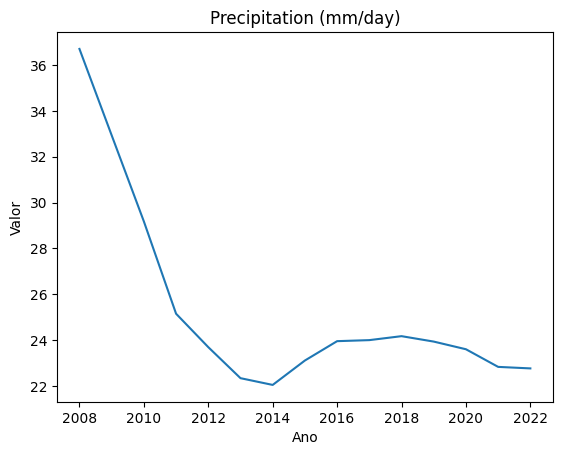

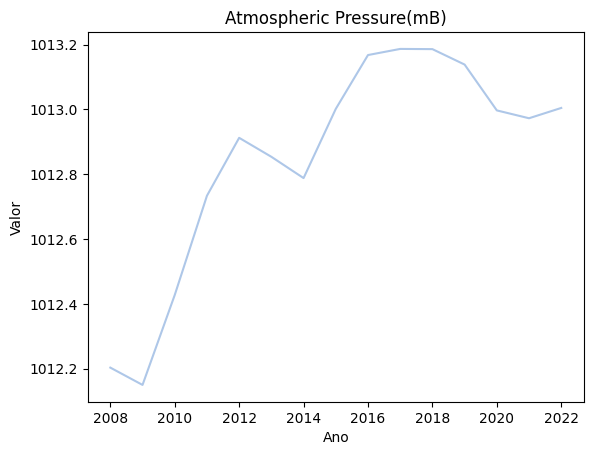

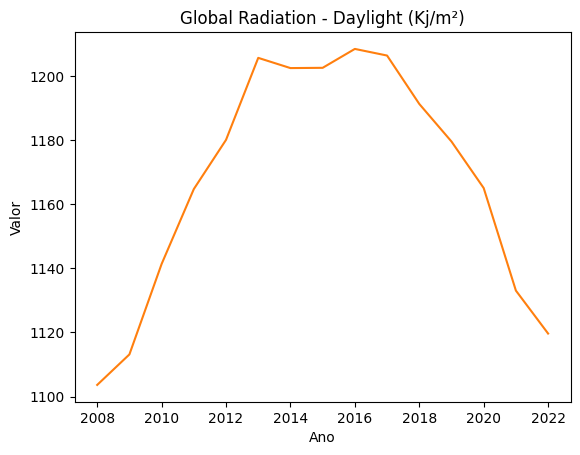

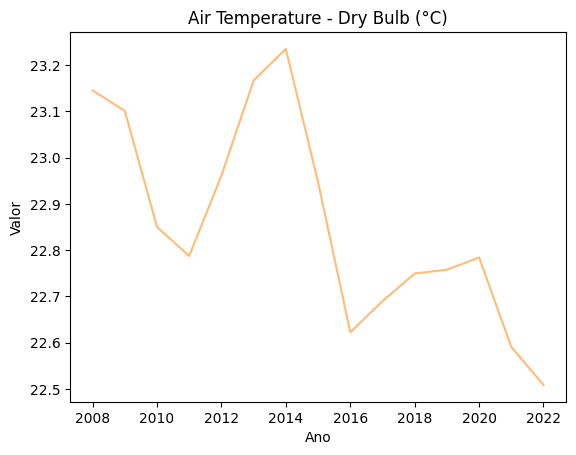

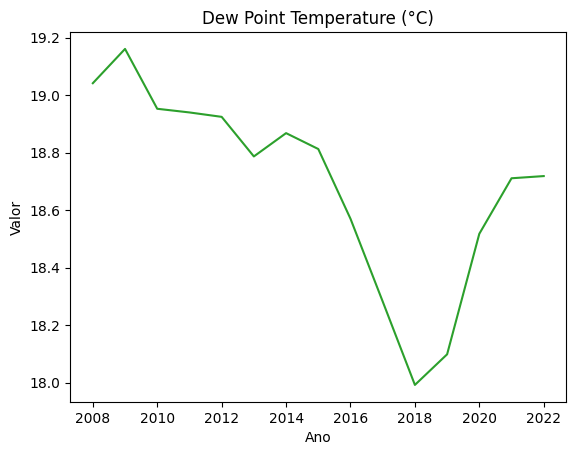

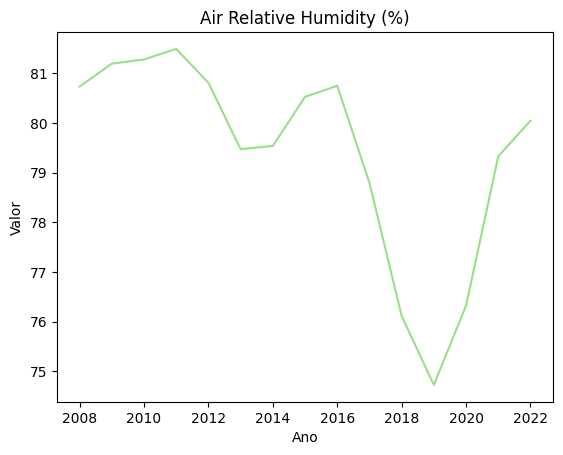

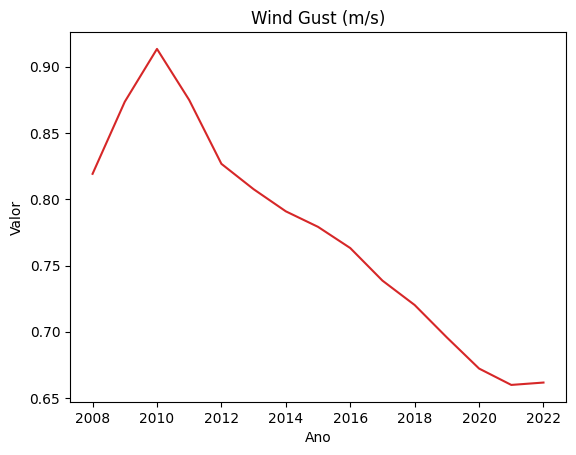

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,36.697984,1012.203296,1103.619545,23.145598,19.041313,80.733596,0.819193
2009,32.933440,1012.149927,1113.135070,23.101387,19.160541,81.195790,0.873595
2010,29.177236,1012.427323,1141.349974,22.850128,18.952421,81.281067,0.913459
2011,25.153610,1012.733462,1164.724634,22.787473,18.939670,81.492721,0.874916
2012,23.695979,1012.912153,1180.075995,22.961436,18.924341,80.811760,0.826735
2013,22.343427,1012.853635,1205.657982,23.167187,18.786695,79.473074,0.807596
2014,22.049108,1012.787954,1202.470602,23.235371,18.867735,79.539625,0.790897
2015,23.113331,1013.001425,1202.552964,22.947408,18.812497,80.526411,0.779173
2016,23.956982,1013.167500,1208.448832,22.622476,18.570007,80.750667,0.763191


In [14]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [15]:
df_2008.to_csv('2008_01_meteo.csv', index=True)